In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from halogal.model import *

In [44]:
model = HODModel(z=5)

obs = Observables(model)


In [45]:
result = obs.compute_correlation_function(MUV_thresh1=-19)

In [51]:
model = HODModel(z=5.0)
obs = Observables(model)

# Initialize once (slow)
result = obs.initialize_correlation_model(
    MUV_thresh1=-19.1,
    correlation_type='angular',
    theta_min=1.0,
    theta_max=7200.0,
    theta_num=50
)

# MCMC loop (fast)
for i in range(10):
    print(i)
    # Sample new parameters
    eps0_new = np.random.uniform(0,1, size=1)
    sigma_UV_new = np.random.uniform(0,1, size=1)
    
    # Update efficiently (uses halomod's update)
    result = obs.update_correlation_model(
        eps0=eps0_new,
        sigma_UV=sigma_UV_new
    )
    
    # Compute likelihood
    w_theta = result['correlation']

/Users/mshuntov/opt/anaconda3/envs/py311/lib/python3.11/site-packages/halomod/integrate_corr.py:567: UserWarning: Filter function p(x) did not integrate to 1 (0.9544997333075783). Tentatively re-normalising.
  p1 = _check_p(p1, z if p_of_z else x)
/Users/mshuntov/opt/anaconda3/envs/py311/lib/python3.11/site-packages/hmf/_internals/_cache.py:115: UserWarning: Using halofit for tracer stats is only valid up to quasi-linear scales k<~1 (h/Mpc).
  value = f(self)


0
1
2
3
4
5
6
7
8
9


In [40]:
result2 = obs.update_correlation_model(MUV_thresh1=-19, eps0=0.3)

ANGULAR CORRELATION FUNCTION PARAMETER SENSITIVITY

[1/2] Creating multi-parameter overview plot...
Creating base HOD model...
Initializing angular correlation model (this may take a minute)...
  Computed for 20 angular bins

Varying parameters and computing angular correlations...

  eps0:
    0.10: w(10'') = 0.090
    0.15: w(10'') = 0.081
    0.19: w(10'') = 0.078
    0.24: w(10'') = 0.078
    0.28: w(10'') = 0.077

  sigma_UV:
    0.30: w(10'') = 0.060
    0.47: w(10'') = 0.071
    0.65: w(10'') = 0.078
    0.82: w(10'') = 0.078
    1.00: w(10'') = 0.073

  Mcut:
    8.50: w(10'') = 0.078
    9.00: w(10'') = 0.078
    9.50: w(10'') = 0.078
    10.00: w(10'') = 0.078
    10.50: w(10'') = 0.078

  Msat:
    11.50: w(10'') = 0.122
    12.00: w(10'') = 0.091
    12.50: w(10'') = 0.080
    13.00: w(10'') = 0.076
    13.50: w(10'') = 0.075

  asat:
    0.50: w(10'') = 0.080
    0.68: w(10'') = 0.079
    0.85: w(10'') = 0.078
    1.02: w(10'') = 0.078
    1.20: w(10'') = 0.077

  Mc:
    

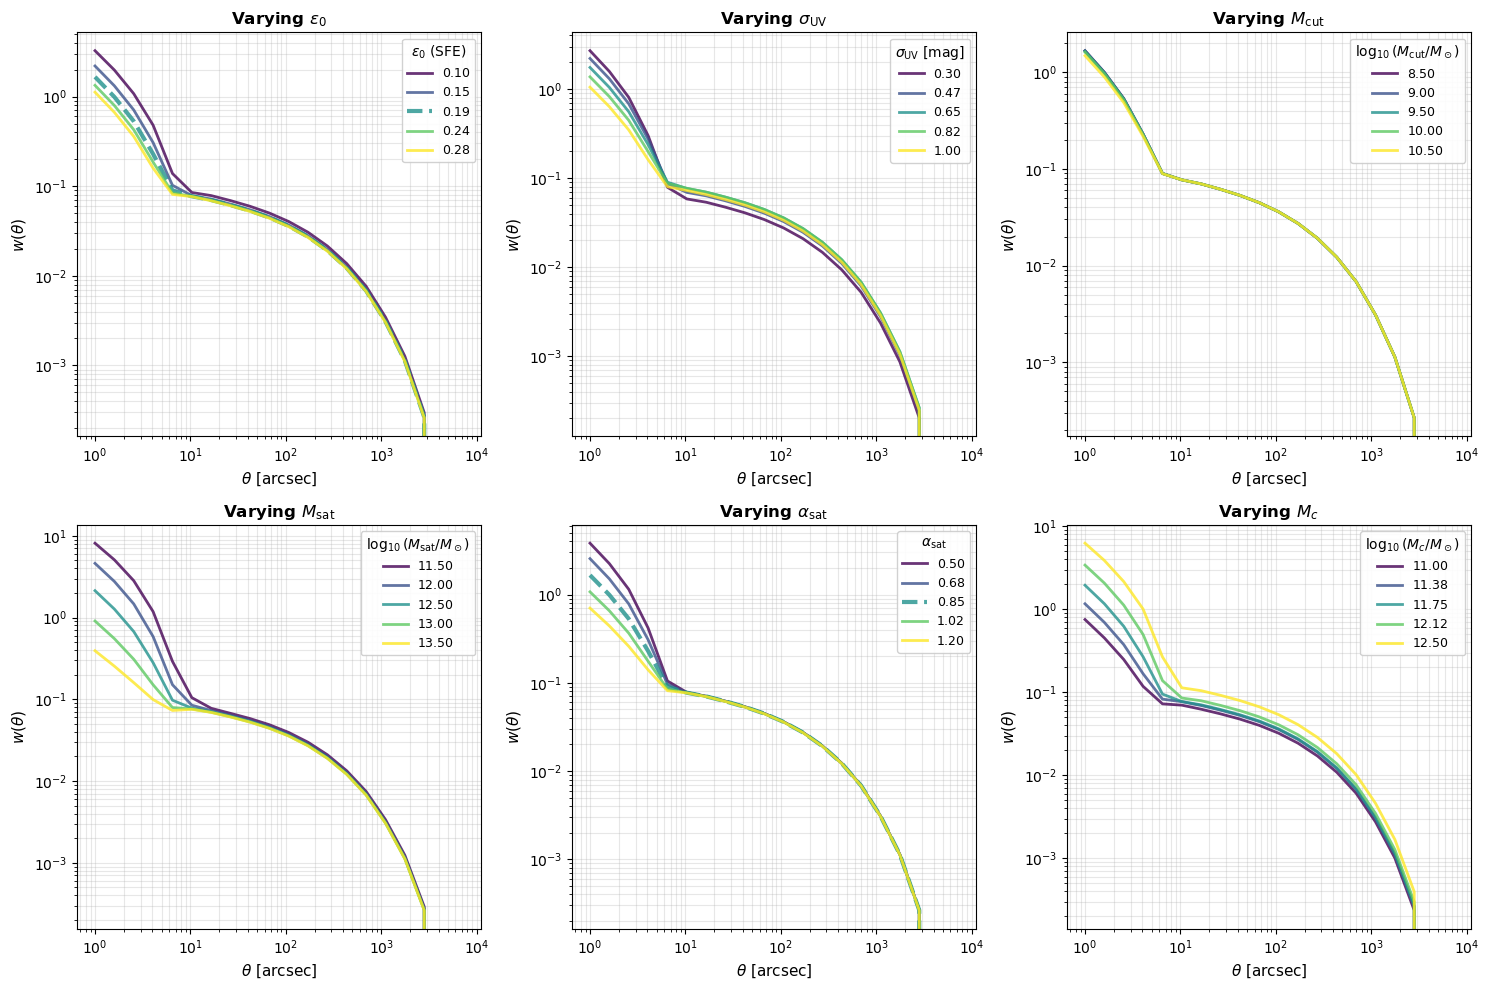

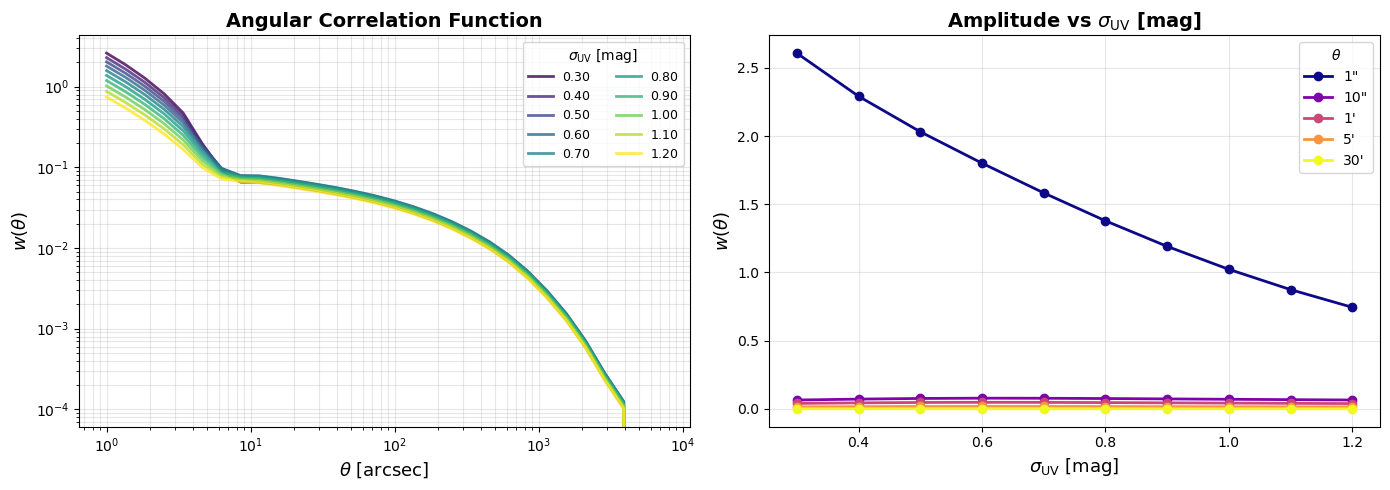

In [54]:
"""Validation plot: Parameter sensitivity of angular correlation function.

This script demonstrates the efficient parameter update functionality
and shows how different HOD parameters affect the angular correlation function.
"""

import numpy as np
import matplotlib.pyplot as plt
from halogal.model import HODModel, Observables

def plot_parameter_sensitivity():
    """Create multi-panel plot showing angular correlation function vs parameters."""
    
    # Create base HOD model
    print("Creating base HOD model...")
    model = HODModel(z=5.0)
    obs = Observables(model)
    
    # Initialize correlation model once (this is the slow step)
    print("Initializing angular correlation model (this may take a minute)...")
    result = obs.initialize_correlation_model(
        MUV_thresh1=-19.1,
        correlation_type='angular',
        theta_min=1.0,      # arcsec
        theta_max=7200.0,   # arcsec (2 degrees)
        theta_num=20,
        zmin=4.0,
        zmax=6.0,
        znum=100,
        Mmin=8,
        Mmax=15,
        dlog10m=0.3,
        dlnk=0.3,
    )
    
    theta = result['separation']  # arcseconds
    print(f"  Computed for {len(theta)} angular bins")
    
    # Define parameters to vary
    params_to_vary = {
        'eps0': {
            'label': r'$\epsilon_0$',
            'default': model.eps0,
            'values': np.linspace(0.10, 0.28, 5),
            'ylabel': r'$\epsilon_0$ (SFE)',
        },
        'sigma_UV': {
            'label': r'$\sigma_{\rm UV}$',
            'default': model.sigma_UV,
            'values': np.linspace(0.3, 1.0, 5),
            'ylabel': r'$\sigma_{\rm UV}$ [mag]',
        },
        'Mcut': {
            'label': r'$M_{\rm cut}$',
            'default': model.Mcut,
            'values': np.logspace(8.5, 10.5, 5),
            'ylabel': r'$\log_{10}(M_{\rm cut}/M_\odot)$',
            'log': True,
        },
        'Msat': {
            'label': r'$M_{\rm sat}$',
            'default': model.Msat,
            'values': np.logspace(11.5, 13.5, 5),
            'ylabel': r'$\log_{10}(M_{\rm sat}/M_\odot)$',
            'log': True,
        },
        'asat': {
            'label': r'$\alpha_{\rm sat}$',
            'default': model.asat,
            'values': np.linspace(0.5, 1.2, 5),
            'ylabel': r'$\alpha_{\rm sat}$',
        },
        'Mc': {
            'label': r'$M_c$',
            'default': model.Mc,
            'values': np.logspace(11.0, 12.5, 5),
            'ylabel': r'$\log_{10}(M_c/M_\odot)$',
            'log': True,
        },
    }
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    colors = plt.cm.viridis(np.linspace(0, 1, 5))
    
    print("\nVarying parameters and computing angular correlations...")
    
    for idx, (param_name, param_info) in enumerate(params_to_vary.items()):
        ax = axes[idx]
        
        print(f"\n  {param_name}:")
        
        for i, value in enumerate(param_info['values']):
            # Update parameter efficiently
            update_kwargs = {param_name: value}
            result = obs.update_correlation_model(**update_kwargs)
            
            w_theta = result['correlation']
            
            # Determine label
            if param_info.get('log', False):
                label = f"{np.log10(value):.2f}"
            else:
                label = f"{value:.2f}"
            
            # Check if this is the default value
            is_default = np.isclose(value, param_info['default'], rtol=0.01)
            linestyle = '-' if not is_default else '--'
            linewidth = 2 if not is_default else 3
            
            ax.loglog(theta, w_theta, color=colors[i], linestyle=linestyle, 
                     linewidth=linewidth, label=label, alpha=0.8)
            
            print(f"    {label}: w(10'') = {np.interp(10.0, theta, w_theta):.3f}")
        
        # Formatting
        ax.set_xlabel(r'$\theta$ [arcsec]', fontsize=11)
        ax.set_ylabel(r'$w(\theta)$', fontsize=11)
        ax.set_title(f'Varying {param_info["label"]}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, which='both')
        ax.legend(title=param_info['ylabel'], fontsize=9, 
                 loc='best', framealpha=0.9)
        
        # Reset to default for next parameter
        reset_kwargs = {param_name: param_info['default']}
        obs.update_correlation_model(**reset_kwargs)
    
    plt.tight_layout()
    print("\n✓ Plot saved to: angular_correlation_parameter_sensitivity.png")
    
    return fig


def plot_single_parameter_detailed(param_name='sigma_UV', n_values=10):
    """Create detailed plot for a single parameter with more values.
    
    Parameters
    ----------
    param_name : str
        Parameter to vary ('eps0', 'sigma_UV', 'Mcut', 'Msat', 'asat', 'Mc')
    n_values : int
        Number of parameter values to test
    """
    print(f"\nCreating detailed plot for {param_name}...")
    
    # Create model
    model = HODModel(z=5.0)
    obs = Observables(model)
    
    # Initialize
    print("Initializing angular correlation model...")
    result = obs.initialize_correlation_model(
        MUV_thresh1=-19.1,
        correlation_type='angular',
        theta_min=1.0,
        theta_max=7200.0,
        theta_num=30,
        zmin=4.0,
        zmax=6.0,
        znum=100,
        Mmin=8,
        Mmax=15,
        dlog10m=0.25,
        dlnk=0.25,
    )
    
    theta = result['separation']  # arcseconds
    
    # Define parameter range
    param_configs = {
        'eps0': (0.10, 0.30, r'$\epsilon_0$', False),
        'sigma_UV': (0.3, 1.2, r'$\sigma_{\rm UV}$ [mag]', False),
        'Mcut': (1e8, 1e11, r'$\log_{10}(M_{\rm cut}/M_\odot)$', True),
        'Msat': (1e11, 1e14, r'$\log_{10}(M_{\rm sat}/M_\odot)$', True),
        'asat': (0.3, 1.5, r'$\alpha_{\rm sat}$', False),
        'Mc': (1e10, 1e13, r'$\log_{10}(M_c/M_\odot)$', True),
    }
    
    vmin, vmax, ylabel, is_log = param_configs[param_name]
    
    if is_log:
        values = np.logspace(np.log10(vmin), np.log10(vmax), n_values)
    else:
        values = np.linspace(vmin, vmax, n_values)
    
    # Compute for all values
    print(f"Computing for {n_values} values...")
    w_theta_array = np.zeros((n_values, len(theta)))
    
    for i, value in enumerate(values):
        update_kwargs = {param_name: value}
        result = obs.update_correlation_model(**update_kwargs)
        w_theta_array[i] = result['correlation']
        
        if i % 3 == 0:
            print(f"  {i+1}/{n_values} done")
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left panel: angular correlation functions
    colors = plt.cm.viridis(np.linspace(0, 1, n_values))
    for i, value in enumerate(values):
        if is_log:
            label = f"{np.log10(value):.2f}"
        else:
            label = f"{value:.2f}"
        ax1.loglog(theta, w_theta_array[i], color=colors[i], linewidth=2, 
                  label=label, alpha=0.8)
    
    ax1.set_xlabel(r'$\theta$ [arcsec]', fontsize=13)
    ax1.set_ylabel(r'$w(\theta)$', fontsize=13)
    ax1.set_title(f'Angular Correlation Function', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.legend(title=ylabel, fontsize=9, loc='best', ncol=2)
    
    # Right panel: w(theta) at fixed scales vs parameter
    scales = [1.0, 10.0, 60.0, 300.0, 1800.0]  # arcsec
    scale_labels = ['1"', '10"', "1'", "5'", "30'"]
    scale_colors = plt.cm.plasma(np.linspace(0, 1, len(scales)))
    
    for j, (scale, scale_label) in enumerate(zip(scales, scale_labels)):
        w_at_scale = np.array([np.interp(scale, theta, w_theta_array[i]) 
                                for i in range(n_values)])
        
        if is_log:
            ax2.semilogx(values, w_at_scale, 'o-', color=scale_colors[j],
                        linewidth=2, markersize=6, label=scale_label)
        else:
            ax2.plot(values, w_at_scale, 'o-', color=scale_colors[j],
                    linewidth=2, markersize=6, label=scale_label)
    
    ax2.set_xlabel(ylabel, fontsize=13)
    ax2.set_ylabel(r'$w(\theta)$', fontsize=13)
    ax2.set_title(f'Amplitude vs {ylabel}', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(title=r'$\theta$', fontsize=10, loc='best')
    
    plt.tight_layout()
    filename = f'angular_correlation_detailed_{param_name}.png'
    print(f"\n✓ Plot saved to: {filename}")
    
    return fig


print("="*70)
print("ANGULAR CORRELATION FUNCTION PARAMETER SENSITIVITY")
print("="*70)

# Multi-panel overview
print("\n[1/2] Creating multi-parameter overview plot...")
fig1 = plot_parameter_sensitivity()

# Detailed plot for sigma_UV
print("\n[2/2] Creating detailed plot for sigma_UV...")
fig2 = plot_single_parameter_detailed('sigma_UV', n_values=10)

print("\n" + "="*70)
print("DONE!")
print("="*70)
print("\nGenerated files:")
print("  1. angular_correlation_parameter_sensitivity.png")
print("  2. angular_correlation_detailed_sigma_UV.png")
print("\nYou can create more detailed plots with:")
print("  plot_single_parameter_detailed('eps0', n_values=15)")
print("  plot_single_parameter_detailed('Mcut', n_values=15)")

plt.show()


BENCHMARK: MODEL vs OBSERVATIONS (with redshift evolution)
Loading measurements from GitHub repository...
  ✓ Loaded Ha z=4.3: 8 data points
  ✓ Loaded Ha z=5.4: 8 data points
  ✓ Loaded OIII z=7.3: 8 data points

Computing model predictions with redshift evolution...

  Ha z=4.3 (z=4.3):
    Redshift-evolved parameters:
    Computing angular correlation...
      theta range: 0.3 - 494.6 arcsec


/Users/mshuntov/opt/anaconda3/envs/py311/lib/python3.11/site-packages/hmf/density_field/transfer_models.py:232: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/Users/mshuntov/opt/anaconda3/envs/py311/lib/python3.11/site-packages/halomod/integrate_corr.py:567: UserWarning: Filter function p(x) did not integrate to 1 (0.6826894964572259). Tentatively re-normalising.
  p1 = _check_p(p1, z if p_of_z else x)
/Users/mshuntov/opt/anaconda3/envs/py311/lib/python3.11/site-packages/hmf/mass_function/hmf.py:409: UserWarning: Nonlinear mass outside mass range
  warnings.warn("Nonlinear mass outside mass range")
/Users/mshuntov/opt/anaconda3/envs/py311/lib/python3.11/site-packages/hmf/_internals/_cache.py:115: UserWarning: Using halofit for tracer stats is only valid up to quasi-linear scales k<~1 (h/Mpc).
  value = f(se

    ✓ Done

  Ha z=5.4 (z=5.4):
    Redshift-evolved parameters:
    Computing angular correlation...
      theta range: 0.3 - 496.8 arcsec
    ✓ Done

  OIII z=7.3 (z=7.3):
    Redshift-evolved parameters:
    Computing angular correlation...
      theta range: 0.2 - 500.3 arcsec
    ✓ Done

Creating benchmark plot...
✓ Plot saved to: benchmark_angular_correlation.png

Creating residual plot...
✓ Plot saved to: benchmark_residuals.png

GOODNESS OF FIT STATISTICS

Ha z=4.3:
  N_points = 8
  χ² = 12.69
  χ²/dof = 1.59
  Mean fractional difference = 19.4%

Ha z=5.4:
  N_points = 8
  χ² = 20049.29
  χ²/dof = 2506.16
  Mean fractional difference = -843.4%

OIII z=7.3:
  N_points = 8
  χ² = 36795.33
  χ²/dof = 4599.42
  Mean fractional difference = -4691.9%

DONE!

Generated files:
  1. benchmark_angular_correlation.png
  2. benchmark_residuals.png

Note: You may need to adjust MUV_thresh to match your sample selection.


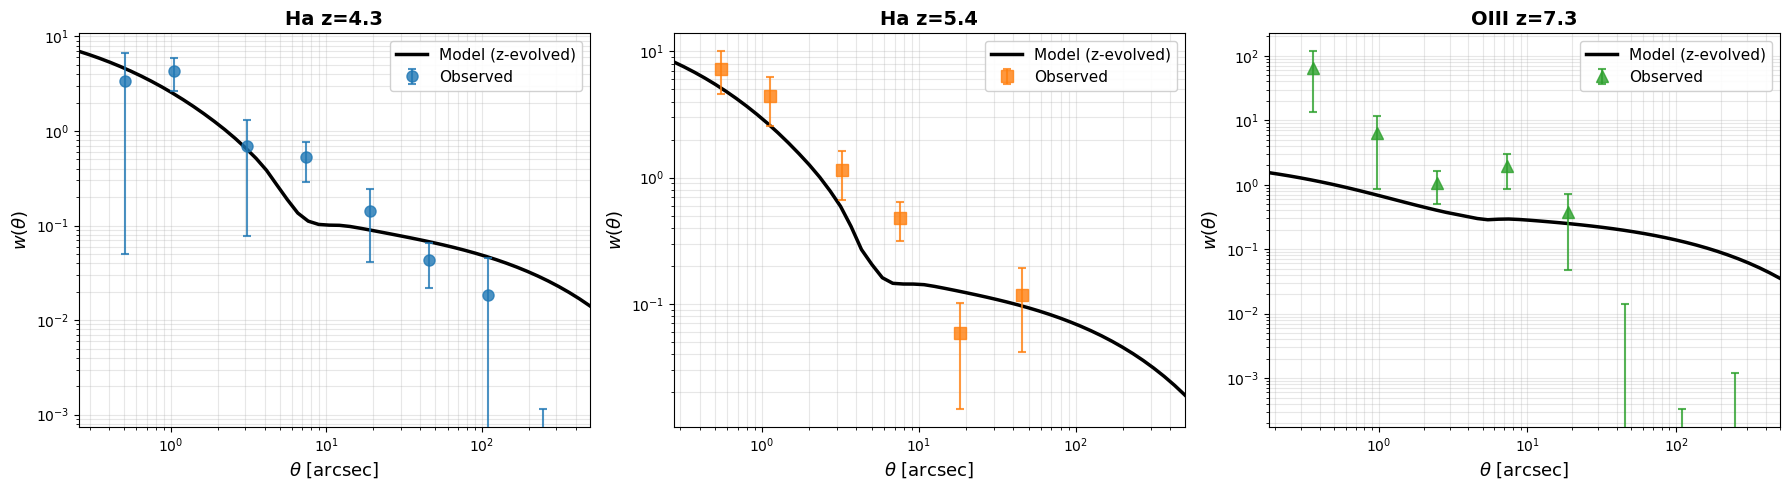

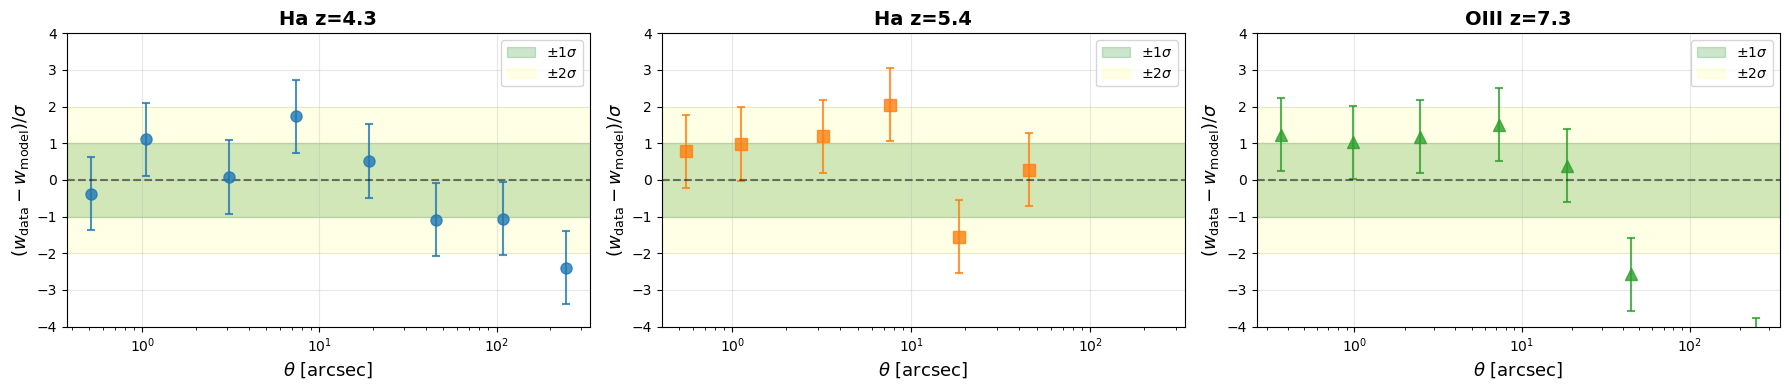

In [62]:
"""Benchmark: Compare model predictions with observed angular correlations.

This script loads measurements from Shuntov et al. and compares them
with HOD model predictions at the corresponding redshifts, using the
redshift-evolved parameter values.
"""

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from halogal.model import HODModel, Observables
from halogal.models.parametrization import (
    eps0_fz, Mc_fz, a_fz, b_fz, sigma_UV_fz, 
    Mcut_fz, Msat_fz, asat_fz
)
from halogal.config import DEFAULT_REDSHIFT_EVOLUTION

def get_parameters_at_redshift(z):
    """Get HOD parameters at a given redshift using evolution relations.
    
    Parameters
    ----------
    z : float
        Redshift
        
    Returns
    -------
    params : dict
        Dictionary of HOD parameters at this redshift
    """
    eps0_z = eps0_fz(
        z,
        deps_dz=DEFAULT_REDSHIFT_EVOLUTION['d_eps0_dz'],
        eps_off=DEFAULT_REDSHIFT_EVOLUTION['C_eps0'])

    Mc_z = 10**Mc_fz(
        z,
        dMc_dz=DEFAULT_REDSHIFT_EVOLUTION['d_logMc_dz'],
        Mc_off=DEFAULT_REDSHIFT_EVOLUTION['C_logMc'])

    a_z = a_fz(
        z,
        da_dz=DEFAULT_REDSHIFT_EVOLUTION['d_a_dz'],
        a_off=DEFAULT_REDSHIFT_EVOLUTION['C_a'])

    b_z = b_fz(
        z,
        db_dz=DEFAULT_REDSHIFT_EVOLUTION['d_b_dz'],
        b_off=DEFAULT_REDSHIFT_EVOLUTION['C_b'])
    
    sigmaUV_z = sigma_UV_fz(
        z,
        dsigmaUV_dz=DEFAULT_REDSHIFT_EVOLUTION['d_sigmaUV_dz'],
        sigmaUV_off=DEFAULT_REDSHIFT_EVOLUTION['C_sigmaUV'])
    
    Mcut_z = 10**Mcut_fz(
        z,
        dMcut_dz=DEFAULT_REDSHIFT_EVOLUTION['d_Mcut_dz'],
        Mcut_off=DEFAULT_REDSHIFT_EVOLUTION['C_Mcut'])
    
    Msat_z = 10**Msat_fz(
        z,
        dMsat_dz=DEFAULT_REDSHIFT_EVOLUTION['d_Msat_dz'],
        Msat_off=DEFAULT_REDSHIFT_EVOLUTION['C_Msat'])
    
    asat_z = asat_fz(
        z,
        dasat_dz=DEFAULT_REDSHIFT_EVOLUTION['d_asat_dz'],
        asat_off=DEFAULT_REDSHIFT_EVOLUTION['C_asat'])
    
    return {
        'eps0': eps0_z,
        'Mc': Mc_z,
        'a': a_z,
        'b': b_z,
        'sigma_UV': sigmaUV_z,
        'Mcut': Mcut_z,
        'Msat': Msat_z,
        'asat': asat_z,
    }


def load_measurements():
    """Load measured angular correlation functions."""
    print("Loading measurements from GitHub repository...")
    
    base_url = "https://raw.githubusercontent.com/mShuntov/Clustering_and_HOD_of_Ha-and-OIII_emitters/main/"
    
    datasets = {
        'Ha z=4.3': {
            'file': base_url + 'w-theta_measurements_ha-z4.3.ecsv',
            'z': 4.3,
            'color': 'C0',
            'marker': 'o',
        },
        'Ha z=5.4': {
            'file': base_url + 'w-theta_measurements_ha-z5.4.ecsv',
            'z': 5.4,
            'color': 'C1',
            'marker': 's',
        },
        'OIII z=7.3': {
            'file': base_url + 'w-theta_measurements_oiii-z7.3.ecsv',
            'z': 7.3,
            'color': 'C2',
            'marker': '^',
        },
    }
    
    data = {}
    for name, info in datasets.items():
        try:
            table = ascii.read(info['file'])
            data[name] = {
                'table': table,
                'z': info['z'],
                'color': info['color'],
                'marker': info['marker'],
            }
            print(f"  ✓ Loaded {name}: {len(table)} data points")
        except Exception as e:
            print(f"  ✗ Failed to load {name}: {e}")
    
    return data


def compute_model_predictions(data):
    """Compute model predictions at each redshift with evolved parameters."""
    print("\nComputing model predictions with redshift evolution...")
    
    predictions = {}
    
    for name, info in data.items():
        z = info['z']
        print(f"\n  {name} (z={z}):")
        
        # Get parameters at this redshift
        params_z = get_parameters_at_redshift(z)
    
        print(f"    Redshift-evolved parameters:")
        # print(f"      eps0 = {params_z['eps0']:.3f}")
        # print(f"      Mc = {params_z['Mc']:.2e} M_sun")
        # print(f"      a = {params_z['a']:.3f}")
        # print(f"      b = {params_z['b']:.3f}")
        # print(f"      sigma_UV = {params_z['sigma_UV']:.2f} mag")
        # print(f"      Mcut = {params_z['Mcut']:.2e} M_sun")
        # print(f"      Msat = {params_z['Msat']:.2e} M_sun")
        # print(f"      asat = {params_z['asat']:.2f}")
        
        # Create HOD model with evolved parameters
        model = HODModel(
            z=z,
            eps0=params_z['eps0'],
            Mc=params_z['Mc'],
            a=params_z['a'],
            b=params_z['b'],
            sigma_UV=params_z['sigma_UV'],
            Mcut=params_z['Mcut'],
            Msat=params_z['Msat'],
            asat=params_z['asat'],
        )
        obs = Observables(model)
        
        # Get theta range from data
        table = info['table']
        theta_data = table['theta']  # Should be in arcseconds
        theta_min = np.min(theta_data) * 0.5
        theta_max = np.max(theta_data) * 2.0
        
        print(f"    Computing angular correlation...")
        print(f"      theta range: {theta_min:.1f} - {theta_max:.1f} arcsec")
        
        # Determine MUV threshold (adjust based on your data)
        # This might need to be adjusted based on the actual sample selection
        MUV_thresh = -19.0  # Example threshold
        
        # Compute angular correlation
        result = obs.initialize_correlation_model(
            MUV_thresh1=MUV_thresh,
            correlation_type='angular',
            theta_min=theta_min,
            theta_max=theta_max,
            theta_num=50,
            zmin=z - 0.5,
            zmax=z + 0.5,
            znum=100,
            Mmin=8,
            Mmax=15,
            dlog10m=0.2,
            dlnk=0.2,
        )
        
        predictions[name] = {
            'theta': result['separation'],
            'w_theta': result['correlation'],
            'model': model,
            'params': params_z,
        }
        
        print(f"    ✓ Done")
    
    return predictions


def plot_benchmark(data, predictions):
    """Create benchmark plot comparing data and model."""
    print("\nCreating benchmark plot...")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (name, info) in enumerate(data.items()):
        ax = axes[idx]
        
        # Plot data
        table = info['table']
        theta_data = table['theta']
        w_theta_data = table['w']
        
        # Check if errors are available
        if 'w_err' in table.colnames:
            w_theta_err = table['w_err']
        elif 'w_theta_err_upper' in table.colnames and 'w_theta_err_lower' in table.colnames:
            w_theta_err_upper = table['w_theta_err_upper']
            w_theta_err_lower = table['w_theta_err_lower']
            w_theta_err = [w_theta_err_lower, w_theta_err_upper]
        else:
            w_theta_err = None
        
        # Plot data with errorbars
        ax.errorbar(theta_data, w_theta_data, yerr=w_theta_err,
                   fmt=info['marker'], color=info['color'], markersize=8,
                   capsize=3, capthick=1.5, linewidth=0, elinewidth=1.5,
                   label='Observed', alpha=0.8, zorder=3)
        
        # Plot model
        if name in predictions:
            theta_model = predictions[name]['theta']
            w_theta_model = predictions[name]['w_theta']
            
            ax.plot(theta_model, w_theta_model, '-', color='black',
                   linewidth=2.5, label='Model (z-evolved)', zorder=2)
        
        # Formatting
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$\theta$ [arcsec]', fontsize=13)
        ax.set_ylabel(r'$w(\theta)$', fontsize=13)
        ax.set_title(f'{name}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, which='both')
        ax.legend(fontsize=11, loc='best', framealpha=0.9)
        
        # Set reasonable limits
        ax.set_xlim(theta_data.min() * 0.5, theta_data.max() * 2.0)
    
    plt.tight_layout()
    print("✓ Plot saved to: benchmark_angular_correlation.png")
    
    return fig


def plot_residuals(data, predictions):
    """Create residual plot showing (data - model) / error."""
    print("\nCreating residual plot...")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    
    for idx, (name, info) in enumerate(data.items()):
        ax = axes[idx]
        
        table = info['table']
        theta_data = table['theta']
        w_theta_data = table['w']
        
        # Get errors
        if 'w_err' in table.colnames:
            w_theta_err = table['w_err']
        else:
            w_theta_err = np.ones_like(w_theta_data) * 0.1 * w_theta_data
        
        if name in predictions:
            theta_model = predictions[name]['theta']
            w_theta_model = predictions[name]['w_theta']
            
            # Interpolate model to data points
            w_model_interp = np.interp(theta_data, theta_model, w_theta_model)
            
            # Compute residuals
            residuals = (w_theta_data - w_model_interp) / w_theta_err
            
            # Plot
            ax.errorbar(theta_data, residuals, yerr=1.0,
                       fmt=info['marker'], color=info['color'], markersize=8,
                       capsize=3, capthick=1.5, linewidth=0, elinewidth=1.5,
                       alpha=0.8)
            
            # Zero line
            ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
            
            # ±1σ, ±2σ regions
            ax.axhspan(-1, 1, alpha=0.2, color='green', label=r'$\pm 1\sigma$')
            ax.axhspan(-2, 2, alpha=0.1, color='yellow', label=r'$\pm 2\sigma$')
        
        ax.set_xscale('log')
        ax.set_xlabel(r'$\theta$ [arcsec]', fontsize=13)
        ax.set_ylabel(r'$(w_{\rm data} - w_{\rm model}) / \sigma$', fontsize=13)
        ax.set_title(f'{name}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10, loc='best')
        ax.set_ylim(-4, 4)
    
    plt.tight_layout()
    print("✓ Plot saved to: benchmark_residuals.png")
    
    return fig


def print_statistics(data, predictions):
    """Print goodness-of-fit statistics."""
    print("\n" + "="*70)
    print("GOODNESS OF FIT STATISTICS")
    print("="*70)
    
    for name, info in data.items():
        if name not in predictions:
            continue
        
        table = info['table']
        theta_data = table['theta']
        w_theta_data = table['w']
        
        if 'w_err' in table.colnames:
            w_theta_err = table['w_err']
        else:
            w_theta_err = np.ones_like(w_theta_data) * 0.1 * w_theta_data
        
        theta_model = predictions[name]['theta']
        w_theta_model = predictions[name]['w_theta']
        
        # Interpolate model to data points
        w_model_interp = np.interp(theta_data, theta_model, w_theta_model)
        
        # Compute chi-squared
        chi2 = np.sum(((w_theta_data - w_model_interp) / w_theta_err)**2)
        ndof = len(theta_data)
        chi2_reduced = chi2 / ndof
        
        print(f"\n{name}:")
        print(f"  N_points = {ndof}")
        print(f"  χ² = {chi2:.2f}")
        print(f"  χ²/dof = {chi2_reduced:.2f}")
        
        # Mean fractional difference
        frac_diff = np.abs(w_theta_data - w_model_interp) / w_theta_data
        print(f"  Mean fractional difference = {np.mean(frac_diff)*100:.1f}%")


if __name__ == '__main__':
    print("="*70)
    print("BENCHMARK: MODEL vs OBSERVATIONS (with redshift evolution)")
    print("="*70)
    
    # Load data
    data = load_measurements()
    
    if not data:
        print("\nERROR: No data loaded. Check your internet connection or file paths.")
        exit(1)
    
    # Compute predictions with redshift evolution
    predictions = compute_model_predictions(data)
    
    # Create plots
    fig1 = plot_benchmark(data, predictions)
    fig2 = plot_residuals(data, predictions)
    
    # Print statistics
    print_statistics(data, predictions)
    
    print("\n" + "="*70)
    print("DONE!")
    print("="*70)
    print("\nGenerated files:")
    print("  1. benchmark_angular_correlation.png")
    print("  2. benchmark_residuals.png")
    print("\nNote: You may need to adjust MUV_thresh to match your sample selection.")
    
    plt.show()


NameError: name 'params_z' is not defined